In [1]:
import requests
import zipfile
import io
import os
import yaml
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time
warnings.filterwarnings('ignore')

def generate_data(yamlFile):
    '''
    generate data and return csv names
    '''
    
    url = "http://oasis.caiso.com/oasisapi/SingleZip"
    extract_directory = ""
    csv_list = []
    start_time = yamlFile["start_time"]
    end_time = yamlFile["end_time"]
    forecast_type = yamlFile["forecast_type"]
    market_run_id = yamlFile["market_run_id"]
    execution_type = yamlFile["execution_type"]
    csv_name = f"{start_time}_{end_time}_{forecast_type}_{market_run_id}_{execution_type}.csv"
    csv_name = os.path.join("data", csv_name)
    start_time = datetime.strptime(start_time, "%Y%m%dT%H:%M%z")
    end_time = datetime.strptime(end_time, "%Y%m%dT%H:%M%z")
    merged_data = pd.DataFrame()

    if  not os.path.exists(csv_name):
        while end_time > start_time:
            def request(start_time, end_time):
                params = {
                    "resultformat": "6",
                    "queryname": forecast_type,
                    "market_run_id": market_run_id,
                    "execution_type": execution_type,
                    "version": "1",
                    "startdatetime": start_time.strftime('%Y%m%dT%H:%M%z').replace("+","-"),
                    "enddatetime": min(start_time + timedelta(days=30), end_time).strftime('%Y%m%dT%H:%M%z').replace("+","-")
                }

                response = requests.get(url, params=params)
                while response.status_code == 429:
                    time.sleep(1)
                    response = request(start_time, end_time)
                return response

            response=request(start_time, end_time)
            if response.status_code == 200:
                data = response.content
                zip_data = io.BytesIO(data)
                csv = None
                with zipfile.ZipFile(zip_data, 'r') as zip_ref:
                    file_bytes = zip_ref.read(zip_ref.namelist()[0])
                    merged_data = pd.concat([merged_data, pd.read_csv(io.BytesIO(file_bytes))], ignore_index=True)
            else:
                print("Request failed with status code:", response.status_code)
            
            start_time += timedelta(days=30)
            time.sleep(1)
            
        merged_data.to_csv(csv_name, index=False)
    return csv_name

/var/folders/nc/hpnkj6fx5d586sqp1n7505s40000gn/T/ipykernel_28924/3628570402.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def split_data(csv, yamlFile):
  '''
  split data from one csv to specific dataset
  '''
  
  data = pd.read_csv(csv)

  # print(data.shape)

  zone_id = yamlFile["zone_id"]
  training_set_start = yamlFile["training_set_start"]
  training_set_end = yamlFile["training_set_end"]
  validation_set_start = yamlFile["validation_set_start"]
  validation_set_end = yamlFile["validation_set_end"]
  test_set_start = yamlFile["test_set_start"]
  test_set_end = yamlFile["test_set_end"]
  TAC_AREA_NAME = yamlFile["TAC_AREA_NAME"]
  training_set = data.query(f'OPR_DT <= "{training_set_end}" and OPR_DT >= "{training_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  validation_set = data.query(f'OPR_DT <= "{validation_set_end}" and OPR_DT >= "{validation_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  test_set = data.query(f'OPR_DT <= "{test_set_end}" and OPR_DT >= "{test_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  training_set.loc[:, 'training_type'] = 'training'
  validation_set.loc[:, 'training_type'] = 'validation'
  test_set.loc[:, 'training_type'] = 'test'
  
  return training_set, validation_set, test_set

In [3]:
def limit_display(num_ticks):
  """
  limit display number of x data points
  """
  ax = plt.gca()
  x_ticks = ax.get_xticks()
  x_labels = ax.get_xticklabels()
  step = len(x_ticks) // num_ticks
  ax.set_xticks(x_ticks[::step])
  ax.set_xticklabels(x_labels[::step])
  plt.show()
  


In [4]:
  
def visualization(yamlFile):
  ''' 
  visualize for certain data, generate one graph
  '''
  csv = generate_data(yamlFile)
  training_set, validation_set, test_set = split_data(csv, yamlFile)
  wholedata = pd.concat([training_set, validation_set])
  wholedata = wholedata.sort_values(by="INTERVALSTARTTIME_GMT")
  plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW", hue="training_type", kind="line", height=4, aspect=4)
  label = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
  plot.fig.suptitle(label)
  limit_display(5)
  # os.remove(csv)

In [5]:
def visualize_data():
  warnings.filterwarnings('ignore')
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)

  visualize_id = yamlFile['visualize_id']
  for run_id in visualize_id:
    if not visualize_id[run_id]:
      yamlFile['market_run_id'] = run_id
      yamlFile['execution_type'] = None
      with open('demand.yaml', 'w') as conf:
        yaml.dump(yamlFile, conf)
      visualization(yamlFile)

    else:
      for exec_type in visualize_id[run_id]:
        yamlFile['market_run_id'] = run_id
        yamlFile['execution_type'] = exec_type
        with open('demand.yaml', 'w') as conf:
          yaml.dump(yamlFile, conf)
        visualization(yamlFile)

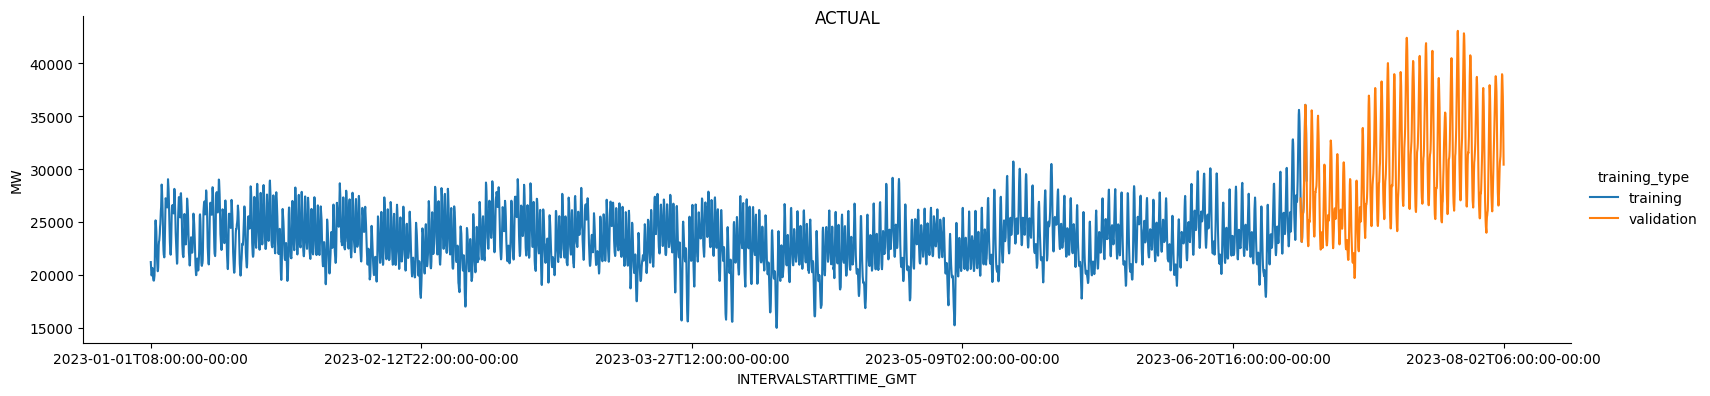

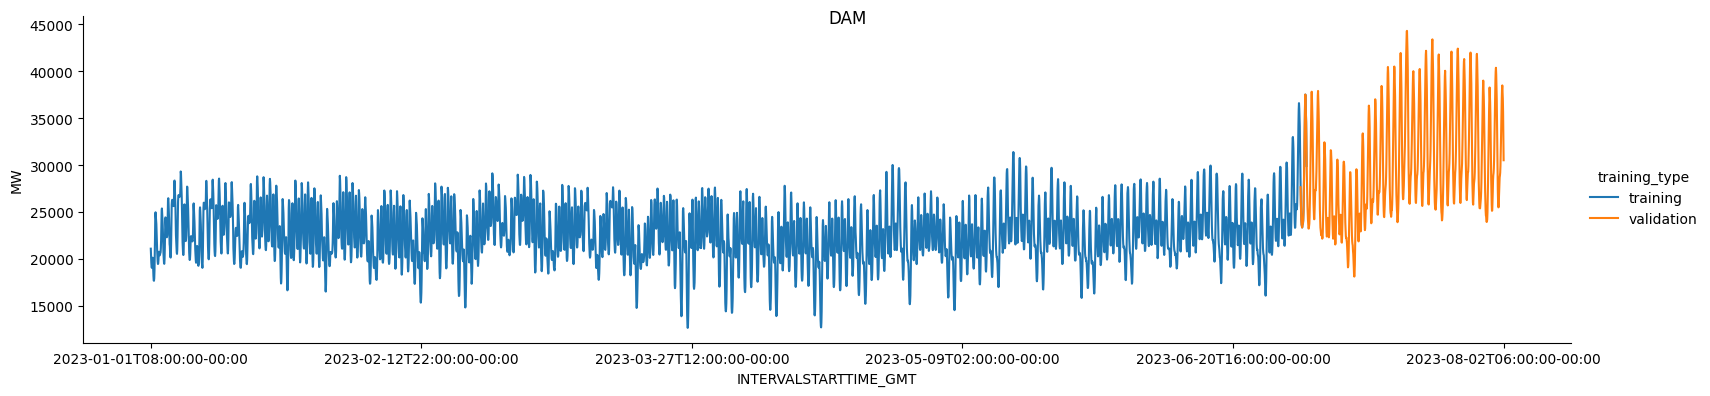

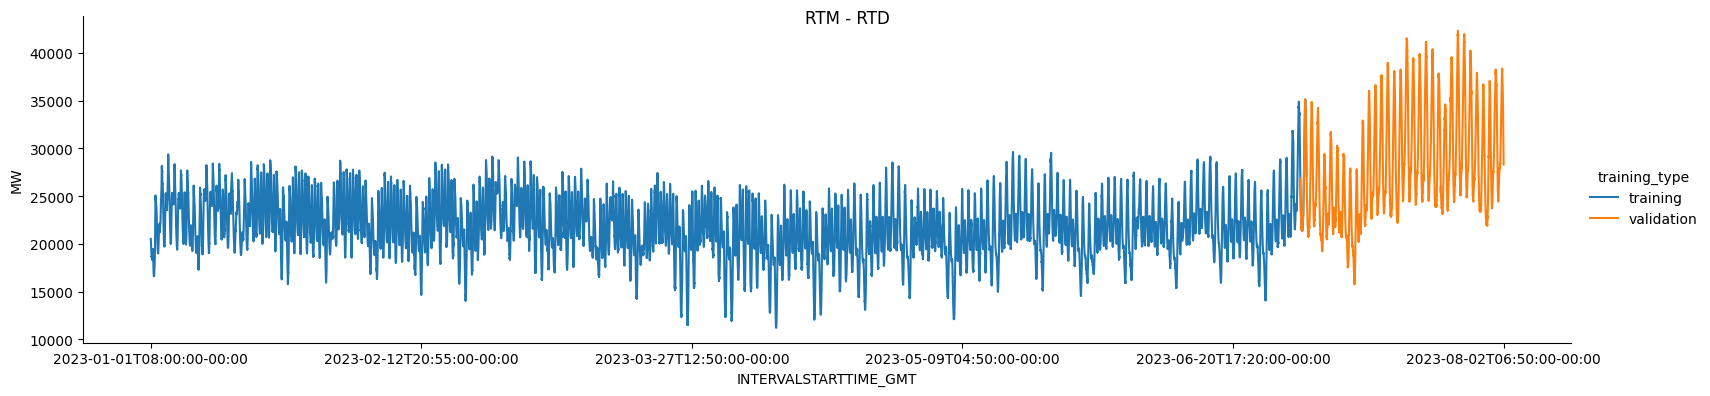

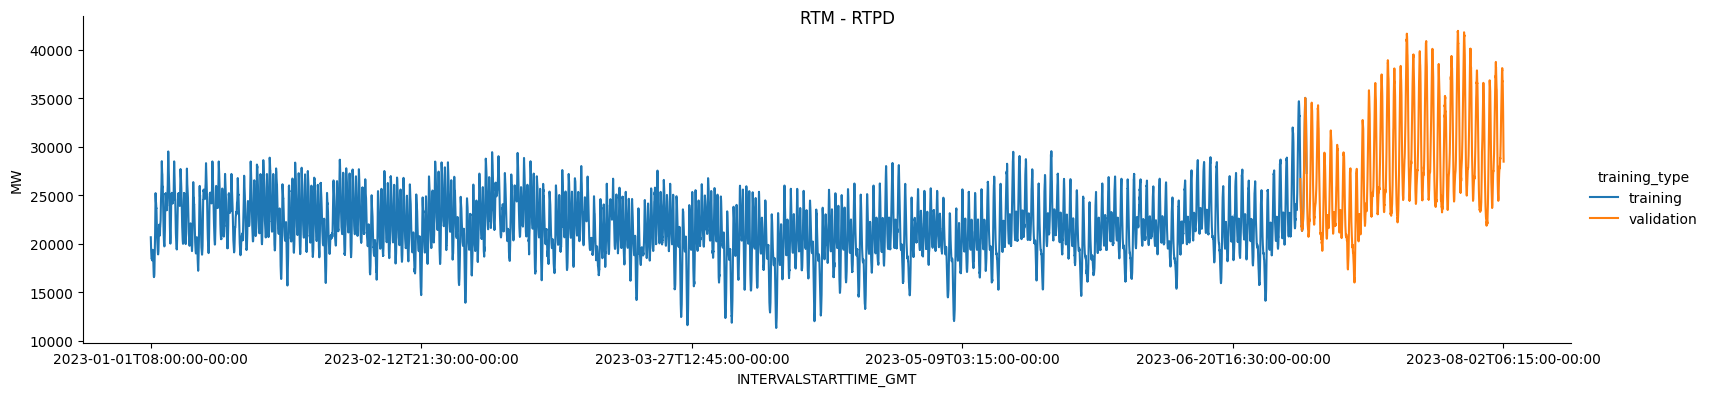

In [6]:
visualize_data()

In [7]:
def visulize_difference():
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)

  minus_visualize_id = yamlFile['minus_visualize']
  for minus_list in minus_visualize_id:
    yamlFile['market_run_id'] = minus_list[0]
    yamlFile['execution_type'] = minus_list[1]
    with open('demand.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
    training_set, validation_set, test_set = split_data(csv, yamlFile)
    wholedata1 = pd.concat([training_set, validation_set])
    # os.remove(csv)
    label1 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
    
    yamlFile['market_run_id'] = minus_list[2]
    yamlFile['execution_type'] = minus_list[3]
    with open('demand.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
    training_set, validation_set, test_set = split_data(csv, yamlFile)
    wholedata2 = pd.concat([training_set, validation_set])
    # os.remove(csv)
    label2 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
    
    wholedata = pd.merge(wholedata1, wholedata2, on='INTERVALSTARTTIME_GMT', suffixes=('_1', '_2'))
    wholedata['MW_diff'] = wholedata['MW_1'] - wholedata['MW_2']
    plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW_diff", hue="training_type_1", kind="line", height=4, aspect=4)
    plot.fig.suptitle(label1+" minus "+label2)
    limit_display(5)

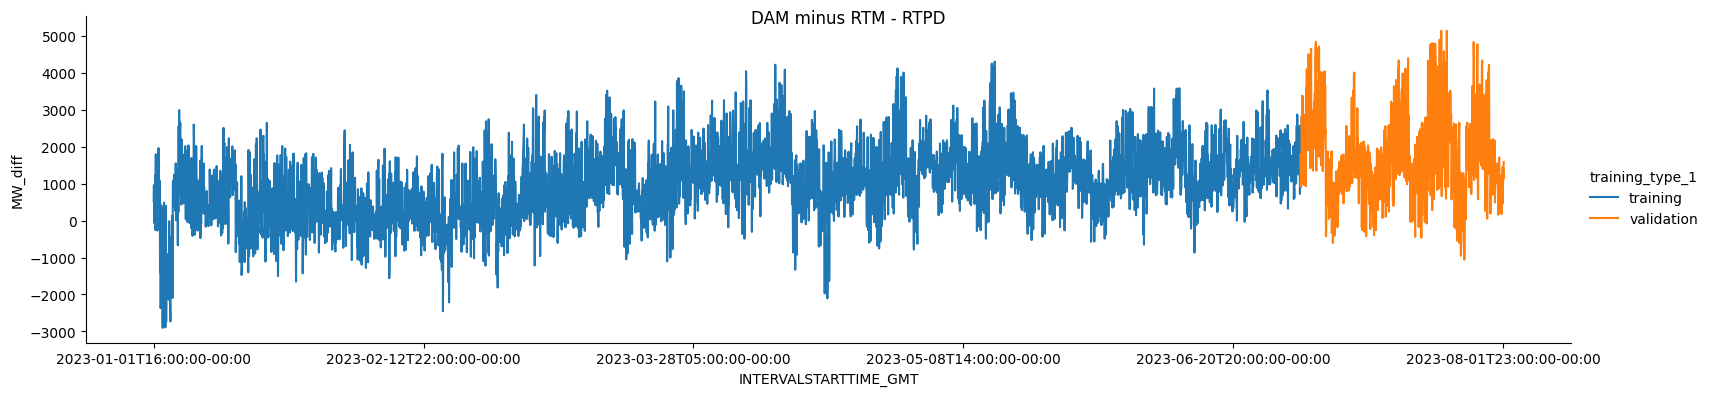

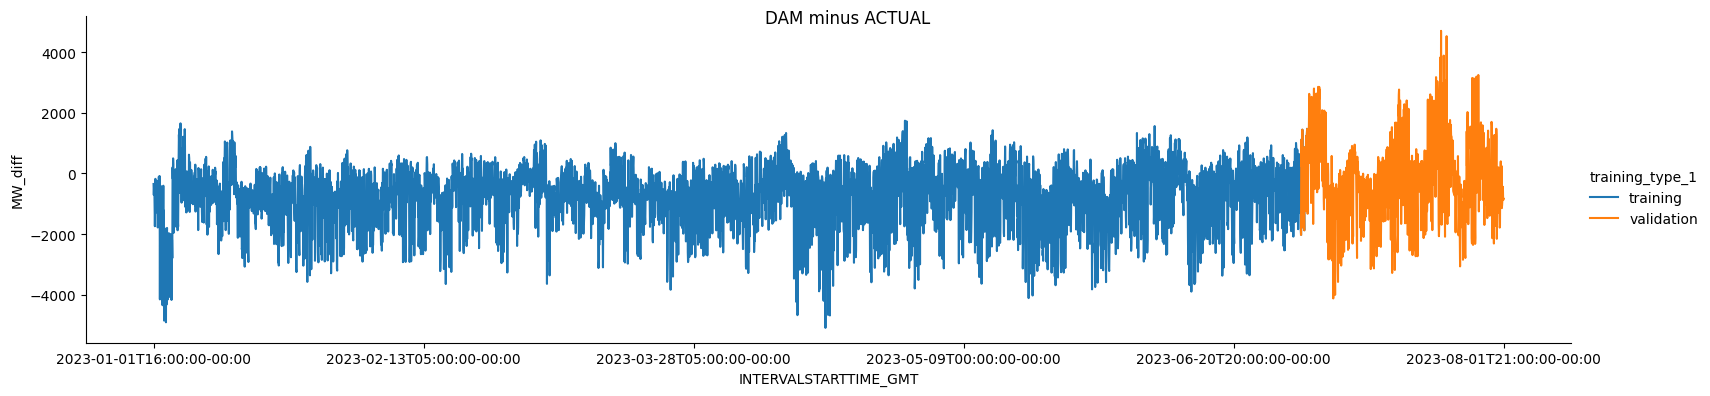

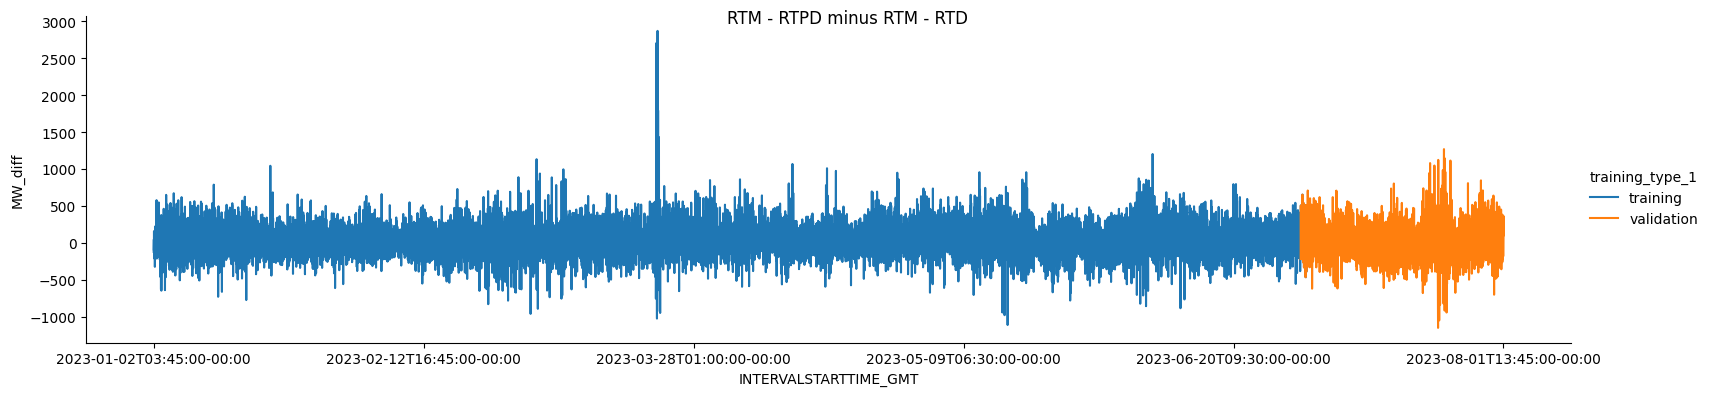

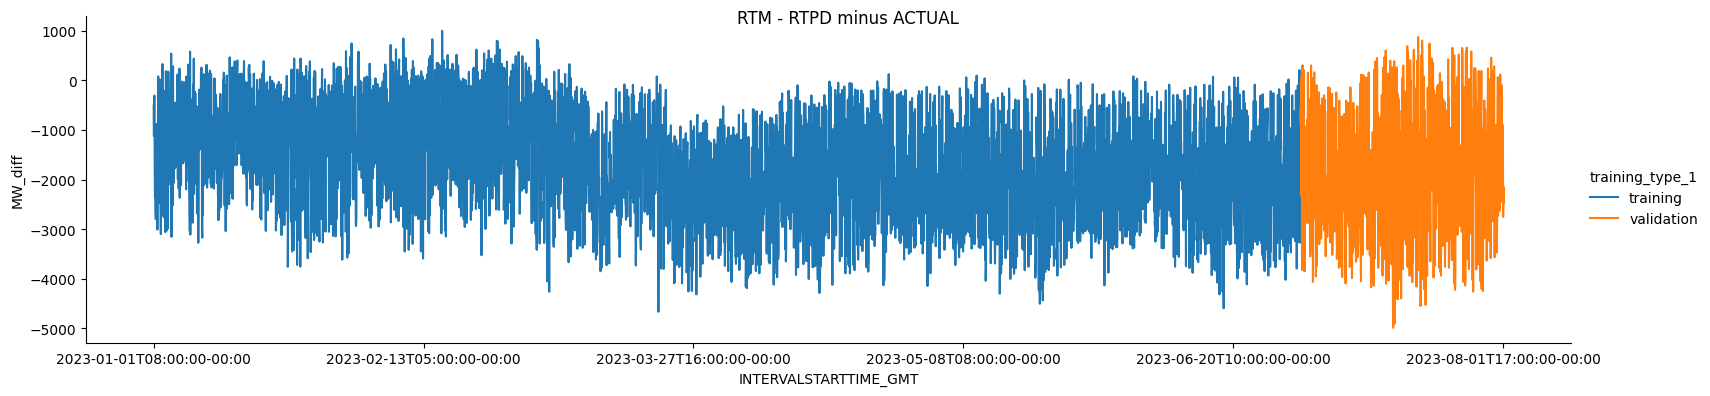

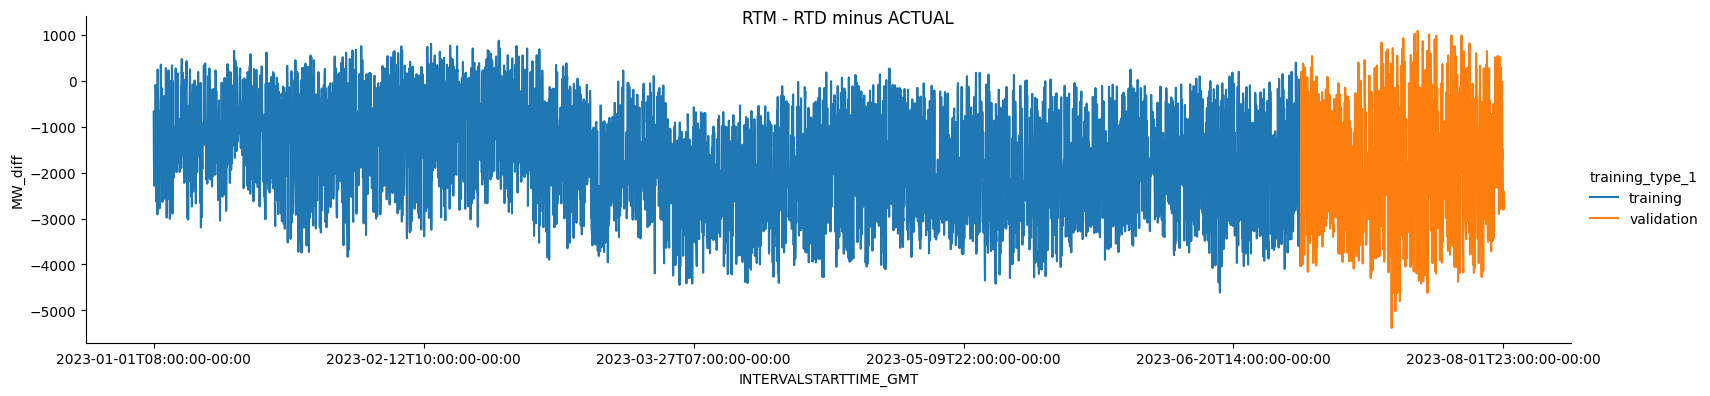

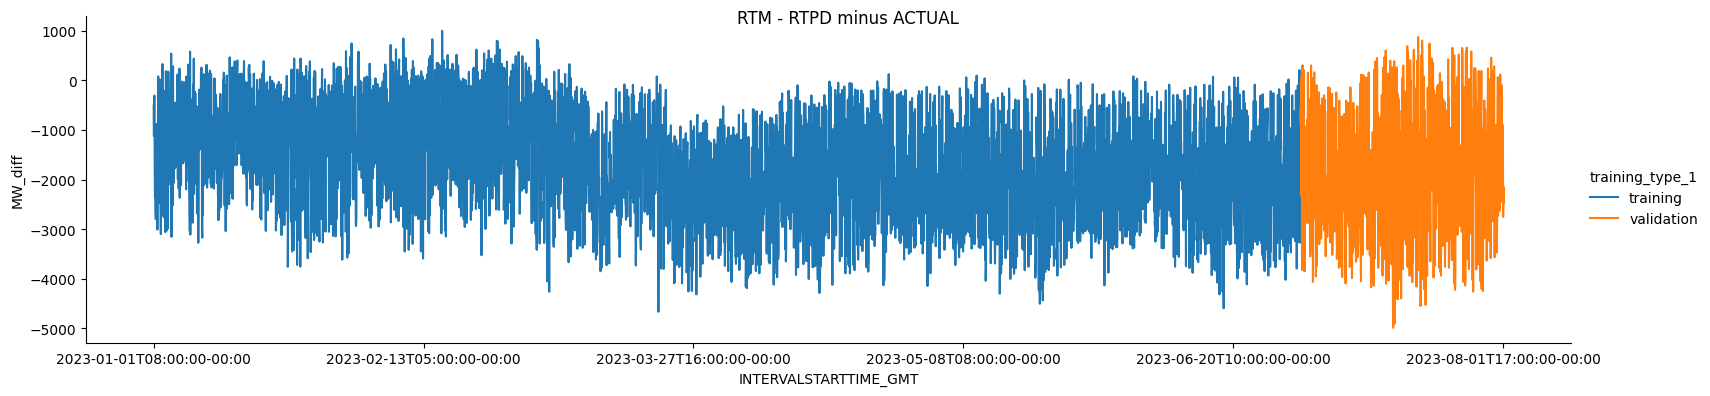

In [8]:
visulize_difference()

In [9]:
def CAISO_forecast():
  ''' 
  get the CAISO forecast data as training set, e.g. DAM
  '''
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)
  with open('demand.yaml', 'w') as conf:
    yamlFile['market_run_id'] = "DAM"
    yamlFile['execution_type'] = None
    yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
  training_set, validation_set, test_set = split_data(csv, yamlFile)
  return np.array(training_set["INTERVALSTARTTIME_GMT"]), np.array(training_set["MW"]), np.array(validation_set["INTERVALSTARTTIME_GMT"]), np.array(validation_set["MW"]), np.array(test_set["INTERVALSTARTTIME_GMT"]), np.array(test_set["MW"])
  
def GodMode():
  ''' 
  get the actual data
  '''
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)
  with open('demand.yaml', 'w') as conf:
    yamlFile['market_run_id'] = "ACTUAL"
    yamlFile['execution_type'] = None
    yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
  training_set, validation_set, test_set = split_data(csv, yamlFile)
  return np.array(training_set["INTERVALSTARTTIME_GMT"]), np.array(training_set["MW"]), np.array(validation_set["INTERVALSTARTTIME_GMT"]), np.array(validation_set["MW"]), np.array(test_set["INTERVALSTARTTIME_GMT"]), np.array(test_set["MW"])
  
def add_gaussian_noise(y, mean=0, std=1):
    noise = np.random.normal(mean, std, y.shape)
    return y + noise

def add_beta_noise(y, alpha=1, beta=1):
    noise = np.random.beta(alpha, beta, y.shape)
    return y + noise

def add_weibull_noise(y, k=1, lambd=1):
    noise = np.random.weibull(k, y.shape) * lambd
    return y + noise

def add_laplace_noise(y, loc=0, scale=1):
    noise = np.random.laplace(loc, scale, y.shape)
    return y + noise
  
def calculate_parameters(target_std, distribution):
    if distribution == 'gaussian':
        std = np.sqrt(target_std)
        return {'mean': 0, 'std': std}
    elif distribution == 'beta':
        alpha = (target_std**2) * (target_std**2 - target_std**4) / (target_std**4)
        beta = alpha * (1 / target_std**2 - 1)
        alpha = max(alpha, 0.01)
        beta = max(beta, 0.01)
        return {'alpha': alpha, 'beta': beta}
    elif distribution == 'weibull':
        k = np.sqrt(target_std**2 / (np.log(1 + (target_std**2)**(-1)) - (np.log(1 + (target_std**2)**(-1)))**2))
        lambd = target_std / np.sqrt(np.exp(np.log(1 + (target_std**2)**(-1)) - (np.log(1 + (target_std**2)**(-1)))**2))
        return {'k': k, 'lambd': lambd}
    elif distribution == 'laplace':
        scale = np.sqrt(target_std / 2)
        return {'loc': 0, 'scale': scale}
    else:
        raise ValueError("Invalid distribution. Supported distributions are 'gaussian', 'beta', 'weibull', 'laplace'.")

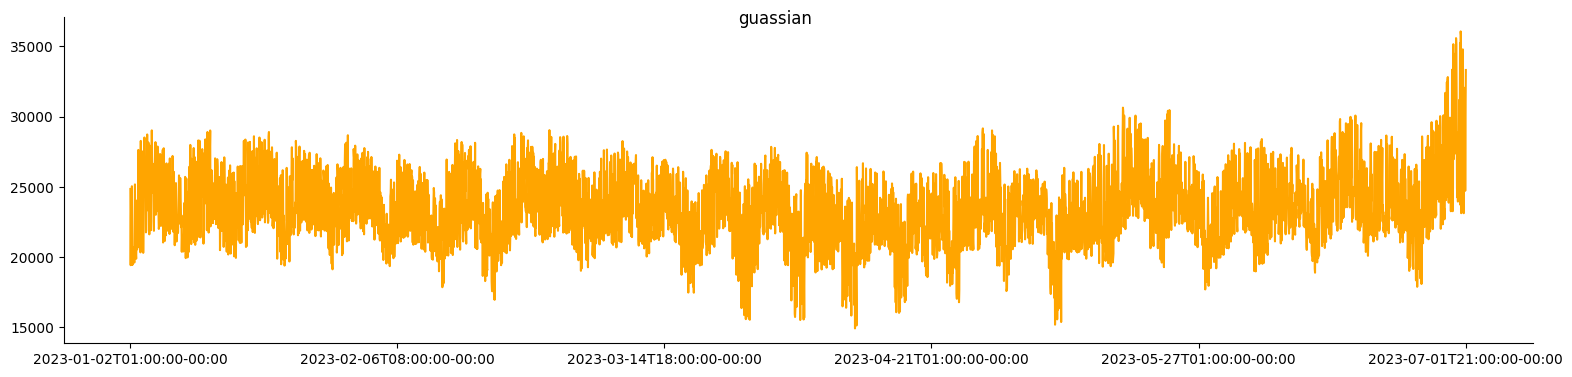

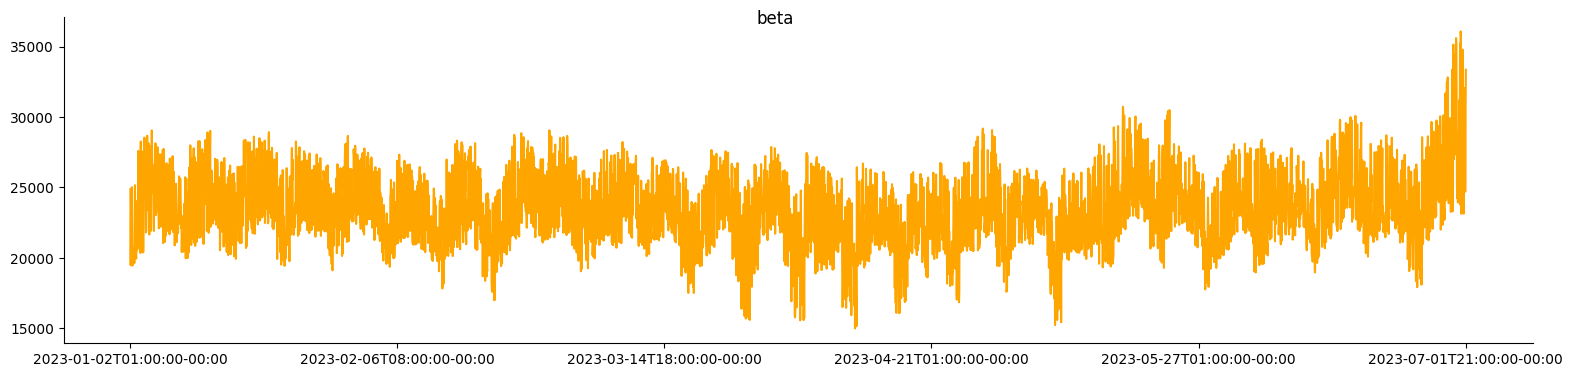

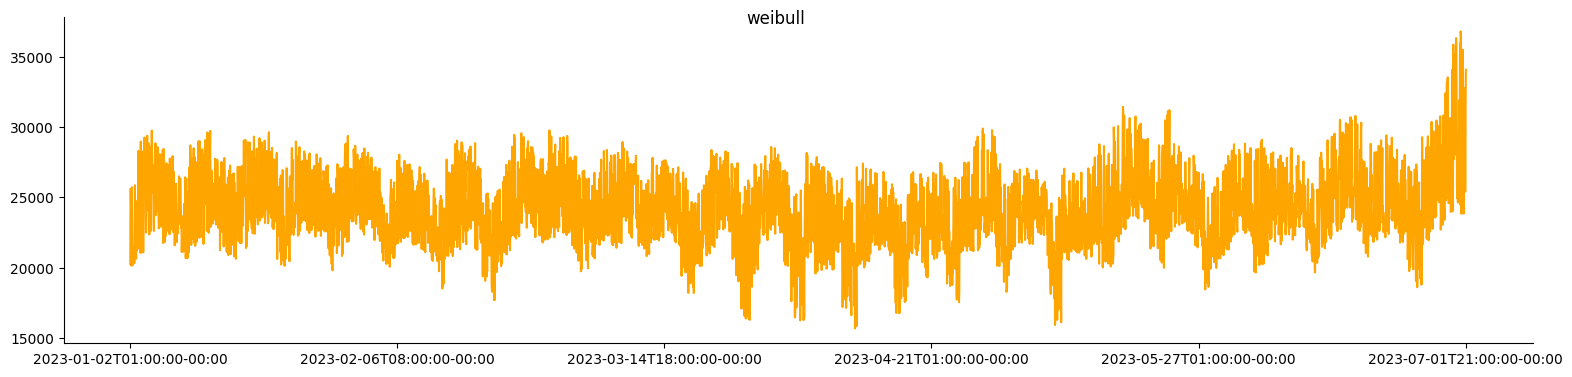

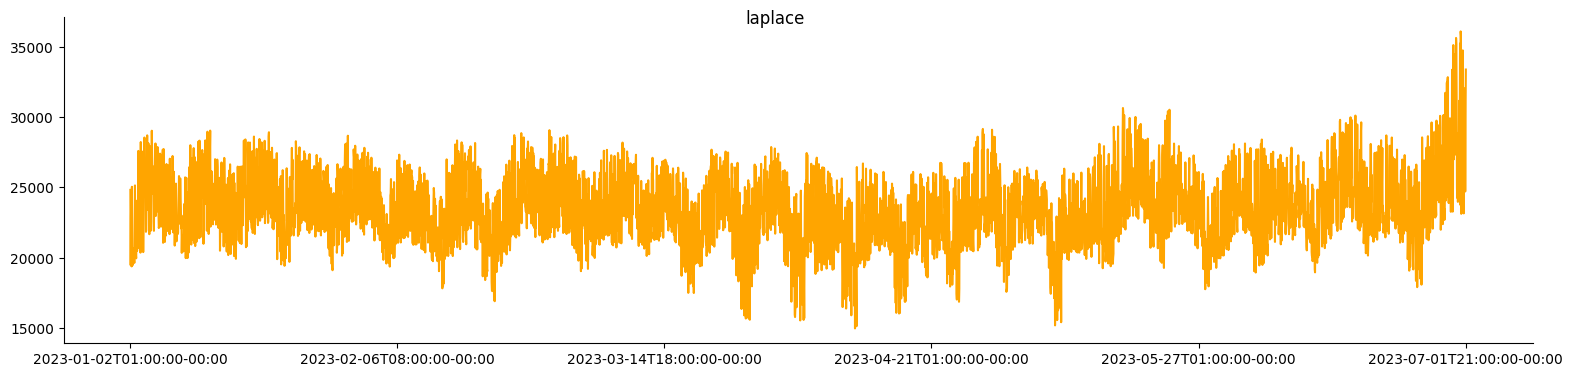

In [11]:
warnings.filterwarnings('ignore')

time_arr, y_DAM, time_arr_val, y_DAM_val, time_arr_test, y_DAM_test = CAISO_forecast()
time_arr, y_truth, time_arr_val, y_truth_val, time_arr_test, y_truth_test = GodMode()



y_guassian = add_gaussian_noise(y_truth, mean=0, std=calculate_parameters(0.02*max(y_truth), "gaussian")["std"])
plot = sns.relplot(x=time_arr, y=y_guassian, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("guassian")
limit_display(5)

y_beta = add_beta_noise(y_truth, alpha=calculate_parameters(0.02*max(y_truth), "beta")["alpha"], beta=calculate_parameters(0.02*max(y_truth), "beta")["beta"])
plot = sns.relplot(x=time_arr, y=y_beta, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("beta")
limit_display(5)

y_weibull = add_weibull_noise(y_truth, k=calculate_parameters(0.02*max(y_truth), "weibull")["k"], lambd=calculate_parameters(0.02*max(y_truth), "weibull")["lambd"])
plot = sns.relplot(x=time_arr, y=y_weibull, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("weibull")
limit_display(5)

y_laplace = add_laplace_noise(y_truth, loc=calculate_parameters(0.02*max(y_truth), "laplace")["loc"], scale=calculate_parameters(0.02*max(y_truth), "laplace")["scale"])
plot = sns.relplot(x=time_arr, y=y_laplace, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("laplace")
limit_display(5)


In [13]:
warnings.filterwarnings('ignore')
time_arr, y_DAM, time_arr_val, y_DAM_val, time_arr_test, y_DAM_test = CAISO_forecast()
time_arr, y_truth, time_arr_val, y_truth_val, time_arr_test, y_truth_test = GodMode()
y_guassian_val = add_gaussian_noise(y_truth_val, mean=0, std=calculate_parameters(0.02*max(y_truth), "gaussian")["std"])
y_beta_val = add_beta_noise(y_truth_val, alpha=calculate_parameters(0.02*max(y_truth), "beta")["alpha"], beta=calculate_parameters(0.02*max(y_truth), "beta")["beta"])
y_weibull_val = add_weibull_noise(y_truth_val, k=calculate_parameters(0.02*max(y_truth), "weibull")["k"], lambd=calculate_parameters(0.02*max(y_truth), "weibull")["lambd"])
y_laplace_val = add_laplace_noise(y_truth_val, loc=calculate_parameters(0.02*max(y_truth), "laplace")["loc"], scale=calculate_parameters(0.02*max(y_truth), "laplace")["scale"])

X_train = np.vstack((y_DAM, y_guassian, y_beta, y_weibull, y_laplace)).reshape((-1,5))
X_val = np.vstack((y_DAM_val, y_guassian_val, y_beta_val, y_weibull_val, y_laplace_val)).reshape((-1,5))
N = len(time_arr)
N_val = len(time_arr_val)
Y_train = y_truth
Y_val = y_truth_val


In [14]:
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')


def KNN(X_train, Y_train, X_val, Y_val, K):
  """
  K nearest neighbour algorithm
  """
  knn = KNeighborsRegressor(n_neighbors=K)
  knn.fit(X_train, Y_train)
  Y_pred = knn.predict(X_val)
  rmse = np.sqrt(np.mean((Y_pred-Y_val)**2))
  print("KNN Model Parameters:", knn.get_params())
  return rmse, Y_pred



def DNN(X_train, Y_train, X_val, Y_val, epoch):
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(5,)))  
  model.add(Dense(64, activation='relu'))  
  model.add(Dense(1))  
  model.compile(optimizer='adam', loss='mse')
  model.fit(X_train, Y_train, epochs=epoch, batch_size=32, verbose=0)
  Y_pred = model.predict(X_val)
  rmse = np.sqrt(np.mean((Y_pred-Y_val)**2))
  print("DNN Model Parameters:", model.get_config())
  return rmse, Y_pred


def LR(X_train, Y_train, X_val, Y_val):
  regression = LinearRegression()
  regression.fit(X_train, Y_train)
  Y_pred = regression.predict(X_val)
  rmse = np.sqrt(np.mean((Y_pred-Y_val)**2))
  print("Intercept:", regression.intercept_)
  print("Coefficients:", regression.coef_)
  
  return rmse, Y_pred
  

In [15]:
print(X_train.shape)
print(Y_train.shape)

(4367, 5)
(4367,)


In [16]:
warnings.filterwarnings('ignore')
for K in [2, 4, 8, 16, 32, 64, 128]:
  rmse_KNN, Y_pred_KNN = KNN(X_train, Y_train, X_val, Y_val, K)
  print(f"K={K}, KNN: {rmse_KNN}")

KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
K=2, KNN: 8168.654009215082
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
K=4, KNN: 8104.047810957306
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
K=8, KNN: 8041.573913200378
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
K=16, KNN: 8097.431108533388
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 32, 'p': 2, 'weights': 'uniform'}
K=32, KNN: 8219.888579364477
K

In [17]:
for epoch in [2, 5, 10, 50, 100, 500]:
  rmse_DNN, Y_pred_DNN = DNN(X_train, Y_train, X_val, Y_val, epoch)
  print(f"epoch:{epoch}, DNN: {rmse_DNN}")

24/24 [==============================] - 0s 362us/step
DNN Model Parameters: {'name': 'sequential', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 5), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 5), 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 5)}}, {'module': 'keras.layers

In [18]:
rmse_LR, Y_pred_LR = LR(X_train, Y_train, X_val, Y_val)
print(f"LR: {rmse_LR}")

Intercept: 25211.071898873455
Coefficients: [-0.02394654 -0.02310672 -0.02313379  0.00347793 -0.01064986]
LR: 9030.337088267881


In [19]:
rmse_LR, Y_pred_LR = LR(np.log(X_train), Y_train, np.log(X_val), Y_val)
print(f"LR: {rmse_LR}")

Intercept: 42575.2248639622
Coefficients: [-631.43524475 -509.59956986 -578.55561288   78.11018712 -265.74013397]
LR: 8981.407725413565


In [20]:
rmse_equal = np.sqrt(np.mean((np.average(X_val, axis=1)-Y_val)**2))
print(rmse_equal)

6191.2141706467


In [36]:
from keras.models import Sequential
from keras.layers import Dense
warnings.filterwarnings('ignore')


time_arr, y_DAM, time_arr_val, y_DAM_val, time_arr_test, y_DAM_test = CAISO_forecast()
time_arr, y_truth, time_arr_val, y_truth_val, time_arr_test, y_truth_test = GodMode()
y_guassian = add_gaussian_noise(y_truth, mean=0, std=calculate_parameters(0.02*max(y_truth), "gaussian")["std"])
y_beta = add_beta_noise(y_truth, alpha=calculate_parameters(0.02*max(y_truth), "beta")["alpha"], beta=calculate_parameters(0.02*max(y_truth), "beta")["beta"])
y_weibull = add_weibull_noise(y_truth, k=calculate_parameters(0.02*max(y_truth), "weibull")["k"], lambd=calculate_parameters(0.02*max(y_truth), "weibull")["lambd"])
y_laplace = add_laplace_noise(y_truth, loc=calculate_parameters(0.02*max(y_truth), "laplace")["loc"], scale=calculate_parameters(0.02*max(y_truth), "laplace")["scale"])
y_guassian_val = add_gaussian_noise(y_truth_val, mean=0, std=calculate_parameters(0.02*max(y_truth), "gaussian")["std"])
y_beta_val = add_beta_noise(y_truth_val, alpha=calculate_parameters(0.02*max(y_truth), "beta")["alpha"], beta=calculate_parameters(0.02*max(y_truth), "beta")["beta"])
y_weibull_val = add_weibull_noise(y_truth_val, k=calculate_parameters(0.02*max(y_truth), "weibull")["k"], lambd=calculate_parameters(0.02*max(y_truth), "weibull")["lambd"])
y_laplace_val = add_laplace_noise(y_truth_val, loc=calculate_parameters(0.02*max(y_truth), "laplace")["loc"], scale=calculate_parameters(0.02*max(y_truth), "laplace")["scale"])
y_guassian_test = add_gaussian_noise(y_truth_test, mean=0, std=calculate_parameters(0.02*max(y_truth), "gaussian")["std"])
y_beta_test = add_beta_noise(y_truth_test, alpha=calculate_parameters(0.02*max(y_truth), "beta")["alpha"], beta=calculate_parameters(0.02*max(y_truth), "beta")["beta"])
y_weibull_test = add_weibull_noise(y_truth_test, k=calculate_parameters(0.02*max(y_truth), "weibull")["k"], lambd=calculate_parameters(0.02*max(y_truth), "weibull")["lambd"])
y_laplace_test = add_laplace_noise(y_truth_test, loc=calculate_parameters(0.02*max(y_truth), "laplace")["loc"], scale=calculate_parameters(0.02*max(y_truth), "laplace")["scale"])

X_train = np.vstack((y_DAM, y_guassian, y_beta, y_weibull, y_laplace)).reshape((-1,5))
X_val = np.vstack((y_DAM_val, y_guassian_val, y_beta_val, y_weibull_val, y_laplace_val)).reshape((-1,5))
X_test = np.vstack((y_DAM_test, y_guassian_test, y_beta_test, y_weibull_test, y_laplace_test)).reshape((-1,5))
N = len(time_arr)
N_val = len(time_arr_val)
N_test = len(time_arr_test)
Y_train = y_truth
Y_val = y_truth_val
Y_test = y_truth_test
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(5,)))  
model.add(Dense(64, activation='relu'))  
model.add(Dense(1))  
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=5, batch_size=32, verbose=0)
Y_pred = model.predict(X_val)
print("DNN Model Parameters:", model.get_config())




24/24 [==============================] - 0s 3ms/step
DNN Model Parameters: {'name': 'sequential_7', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 5), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_21_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_21', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 5), 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 5)}}, {'module': 'keras.

In [38]:
Error = X_test - Y_test[:,np.newaxis]
print(Error)

[[ -5124.02        -2458.77         2720.33         2033.27
   -9531.77      ]
 [ -5794.03         1642.43        -8177.76        -7972.89
   -7676.48      ]
 [ -8989.86        -7473.45        -2368.47       -11650.59
   -9820.41      ]
 ...
 [ -1067.93664027   -930.27794443   7218.78624986   6979.39617691
    1242.51023285]
 [ -3534.78136278   2102.82257739  -1461.74469097  -1307.32139713
   -3980.18692263]
 [  4957.90140375   4077.40856385  -1612.54636757   2498.54408415
      20.77467558]]
